In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
DIR = Path('results')
IMG_DIR = Path('imgs')
IMG_DIR.mkdir(exist_ok=True)

In [3]:
plt.rcParams['font.family'] = 'arial'

In [19]:
# 获取数据
tops = []
steps = []
ecs = []
accs = []
folds = []
for ec in range(5):
    fold_dir = DIR / str(ec)
    for fold in os.listdir(fold_dir):
        step_dir = fold_dir / str(fold)
        for step in os.listdir(step_dir):
            csv_dir = step_dir / str(step)
            for top in range(1, 6):
                ecs.append(str(ec))
                folds.append(str(fold))
                steps.append(int(step))
                tops.append(str(top))
                csv = csv_dir / f'top{top}.csv'
                df = pd.read_csv(csv)
                accs.append(df[(df['ec'] == 'overall') & (df['type'] == 'forward')]['value'].values[0])

In [20]:
df = pd.DataFrame({'ec': ecs, 'top': tops, 'acc': accs, 'step': steps, 'fold': folds})
df.head()

,ec,top,acc,step,fold
0,0,1,0.635708,10000,1
1,0,2,0.731289,10000,1
2,0,3,0.768260,10000,1
3,0,4,0.781785,10000,1
4,0,5,0.794409,10000,1


In [21]:
"""top-1 随 steps 的增加而增加"""
top_step_df = df[df['top'] == '1']
top_step_df.head()

,ec,top,acc,step,fold
0,0,1,0.635708,10000,1
5,0,1,0.719567,20000,1
10,0,1,0.429216,5000,1
15,0,1,0.784491,45000,1
20,0,1,0.767358,30000,1


In [22]:
# 拿各自最好的 step 来比较
means = []
ecs = []
steps = []
for (step, ec), group in top_step_df.groupby(['step', 'ec']):
    means.append(group['acc'].mean())
    steps.append(step)
    ecs.append(ec)
mean_top_step_df = pd.DataFrame({'ec': ecs, 'acc': means, 'step': steps})
mean_top_step_df.head()

,ec,acc,step
0,0,0.426435,5000
1,1,0.481070,5000
2,2,0.484132,5000
3,3,0.507037,5000
4,4,0.529932,5000


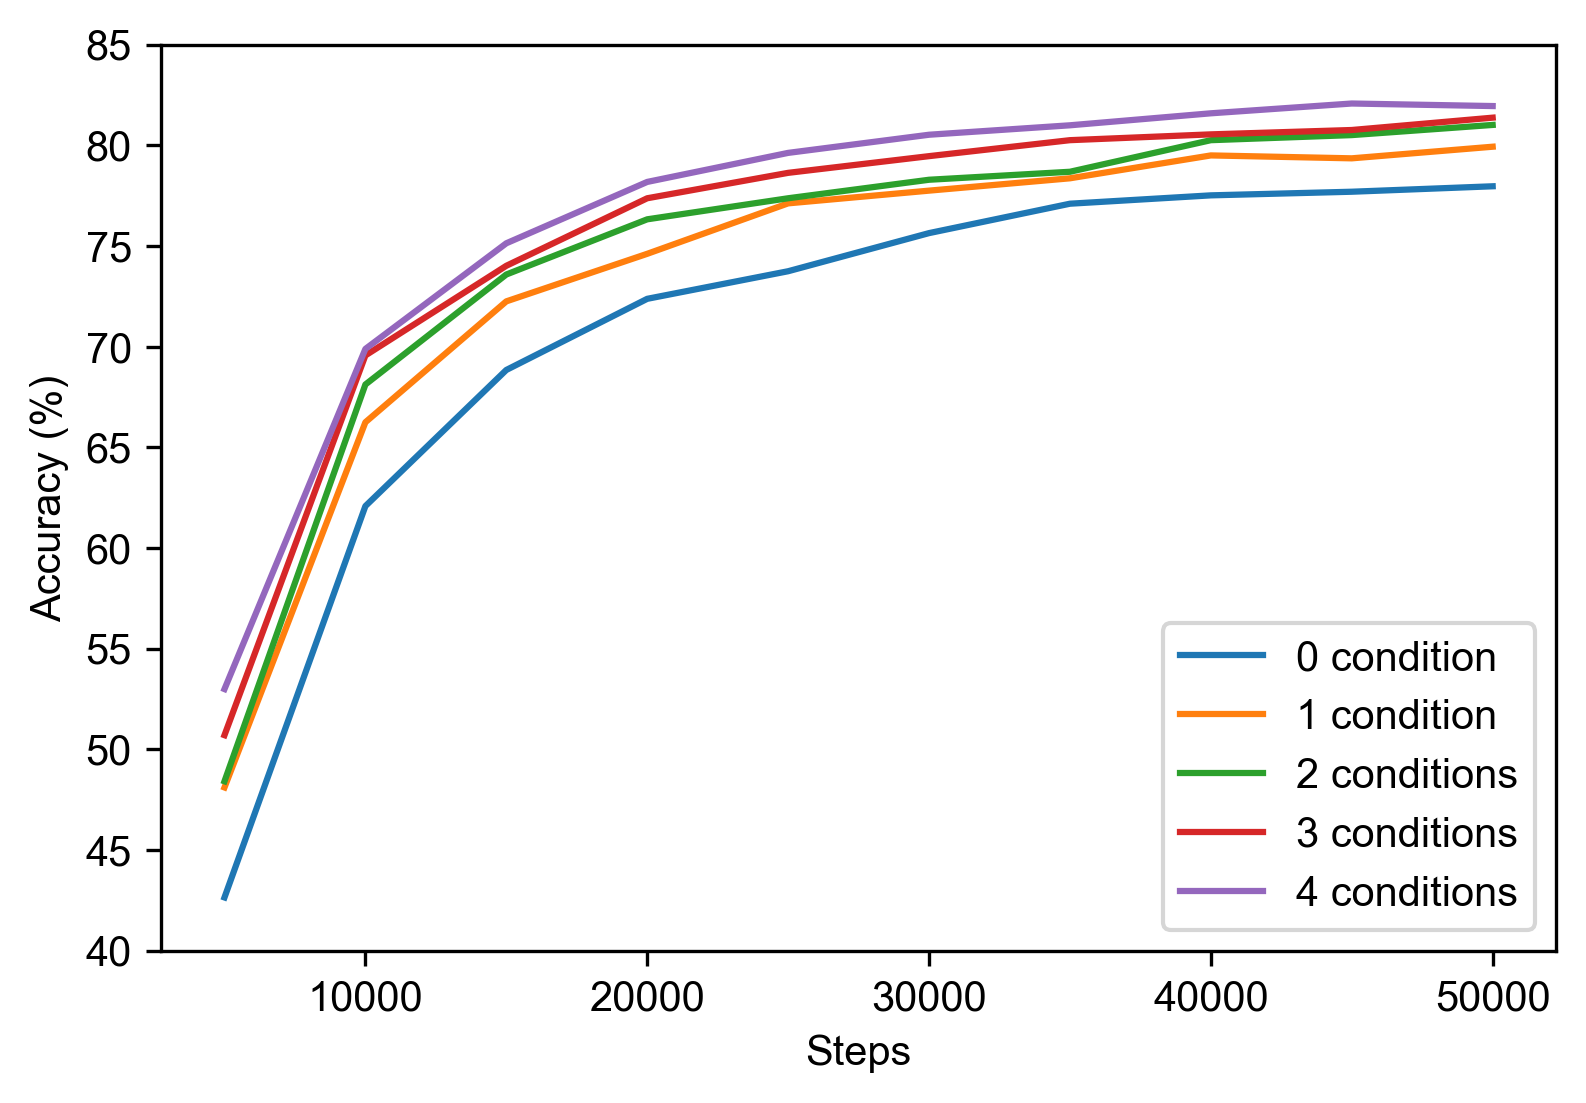

In [23]:
fig, ax = plt.subplots(dpi=300)
for ec, group in mean_top_step_df.groupby('ec'):
    label = f'{ec} condition' if ec == '0' or ec == '1' else f'{ec} conditions'
    ax.plot('step', 'acc', data=group, label=label)
yticks = np.linspace(0.4, 0.85, 10)
yticks_label = [f'{round(x*100)}' for x in yticks]
plt.yticks(ticks=yticks,labels=yticks_label)
plt.xlabel("Steps")
plt.ylabel("Accuracy (%)")
# plt.title('Reaction Condition Counts')
plt.legend(loc='best')
plt.show()


## 箱线图

In [24]:
# 拿各自最好的 step 来比较
bests = []
means = []
for (fold, ec, top), group in df.groupby(['fold', 'ec', 'top']):
    bests.append(group.iloc[group['acc'].argmax()])
best_df = pd.concat(bests, axis=1).T
best_df.head()

,ec,top,acc,step,fold
115,0,1,0.778378,45000,0
116,0,2,0.845045,45000,0
137,0,3,0.875676,50000,0
138,0,4,0.887387,50000,0
139,0,5,0.896396,50000,0


In [25]:
cmap = plt.cm.get_cmap('tab10')

In [26]:
def get_colors_with_alpha(colors, alpha=1.):
        rtn = []
        for color in colors:
                _ = []
                for i in color[:3]:
                        _.append(i)
                _.append(alpha)
                rtn.append(_)
        return rtn
colors = [cmap(0), cmap(1), cmap(2), cmap(3), cmap(6), cmap(8)]
colors = get_colors_with_alpha(colors, 0.5)
colors

[[0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.5],
 [1.0, 0.4980392156862745, 0.054901960784313725, 0.5],
 [0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.5],
 [0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.5],
 [0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 0.5],
 [0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 0.5]]

In [27]:
needed_colors = []
needed_colors.append([i/256 for i in (185,205,229)] + [1.0])
needed_colors.append([i/256 for i in (197,224,180)] + [1.0])
needed_colors.append([i/256 for i in (217,163,208)] + [1.0])
new_colors = [needed_colors[0], colors[1], needed_colors[1], colors[4], colors[5]]

In [28]:
from matplotlib import ticker
def boxplot(df, top):
    fig, ax = plt.subplots(dpi=300)
    bplot = plt.boxplot(df,
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=[str(i) for i in range(5)], showfliers=False, medianprops={'color': 'k'})  # will be used to label x-ticks
    # colors = ['pink', 'lightblue', 'lightgreen', 'orange', 'red']
    for patch, color in zip(bplot['boxes'], new_colors):
        patch.set_facecolor(color)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0, symbol=False))
    ax.set_xlabel('Counts of conditions')
    ax.set_ylabel(f'Top-{top} accuracy (%)')
    plt.show()


In [30]:
best_df.head()

,ec,top,acc,step,fold
115,0,1,0.778378,45000,0
116,0,2,0.845045,45000,0
137,0,3,0.875676,50000,0
138,0,4,0.887387,50000,0
139,0,5,0.896396,50000,0


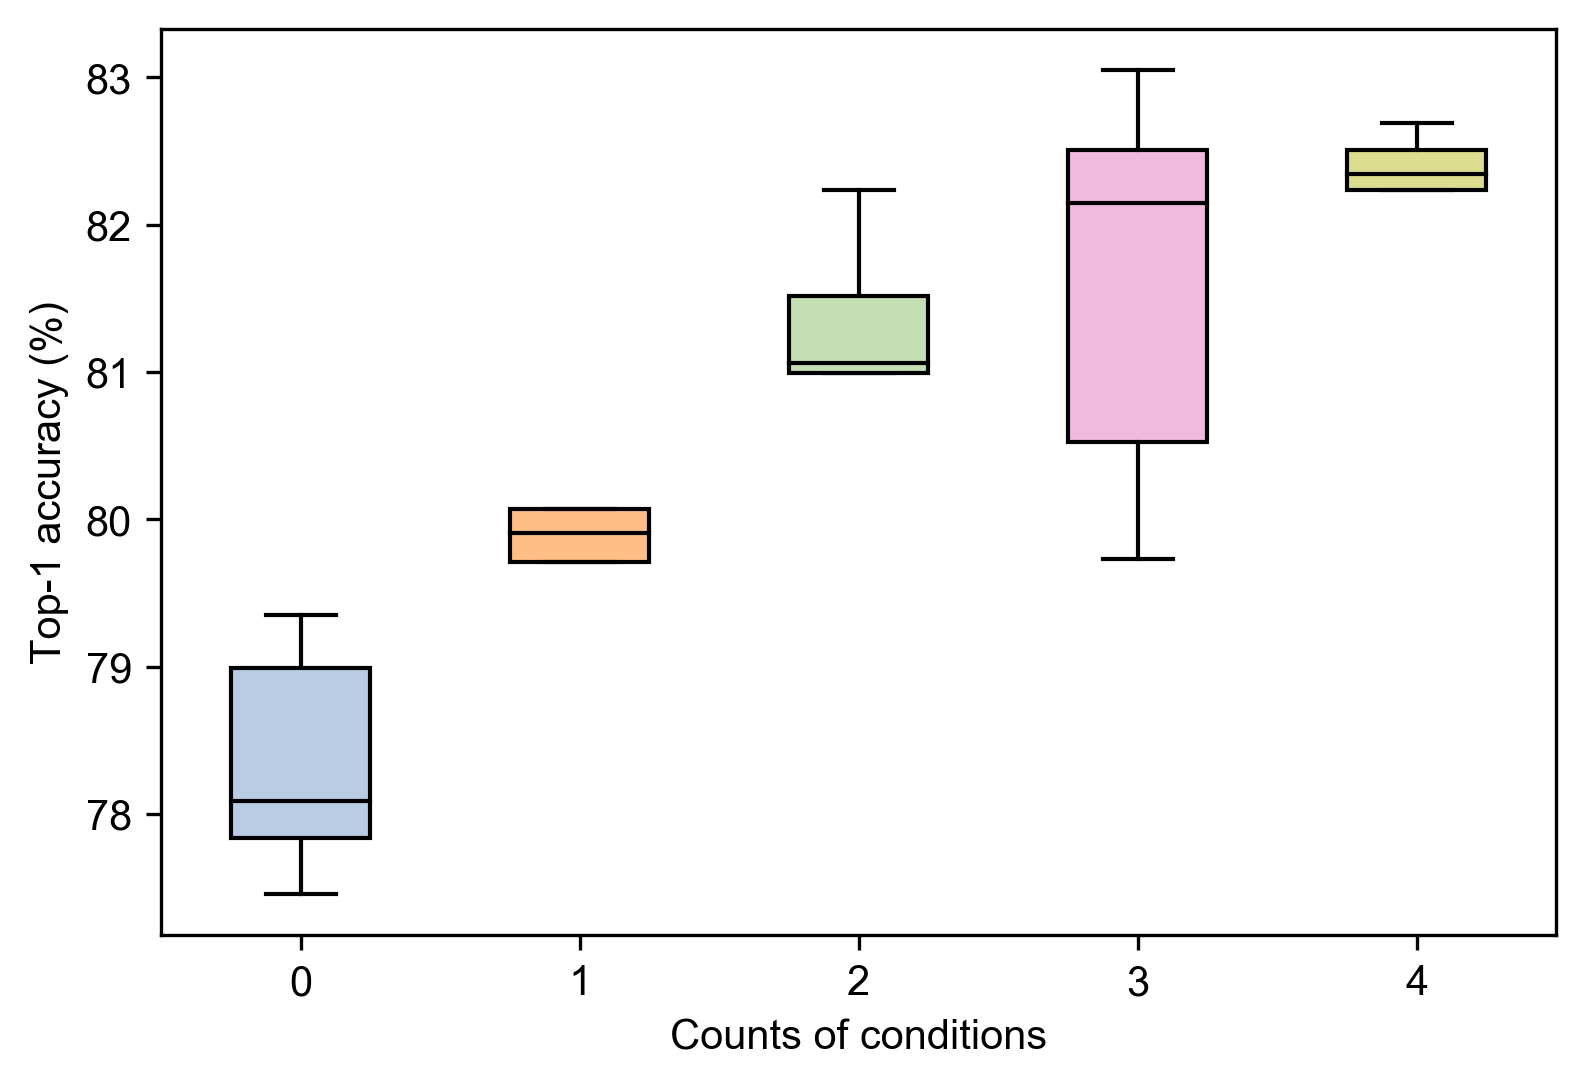

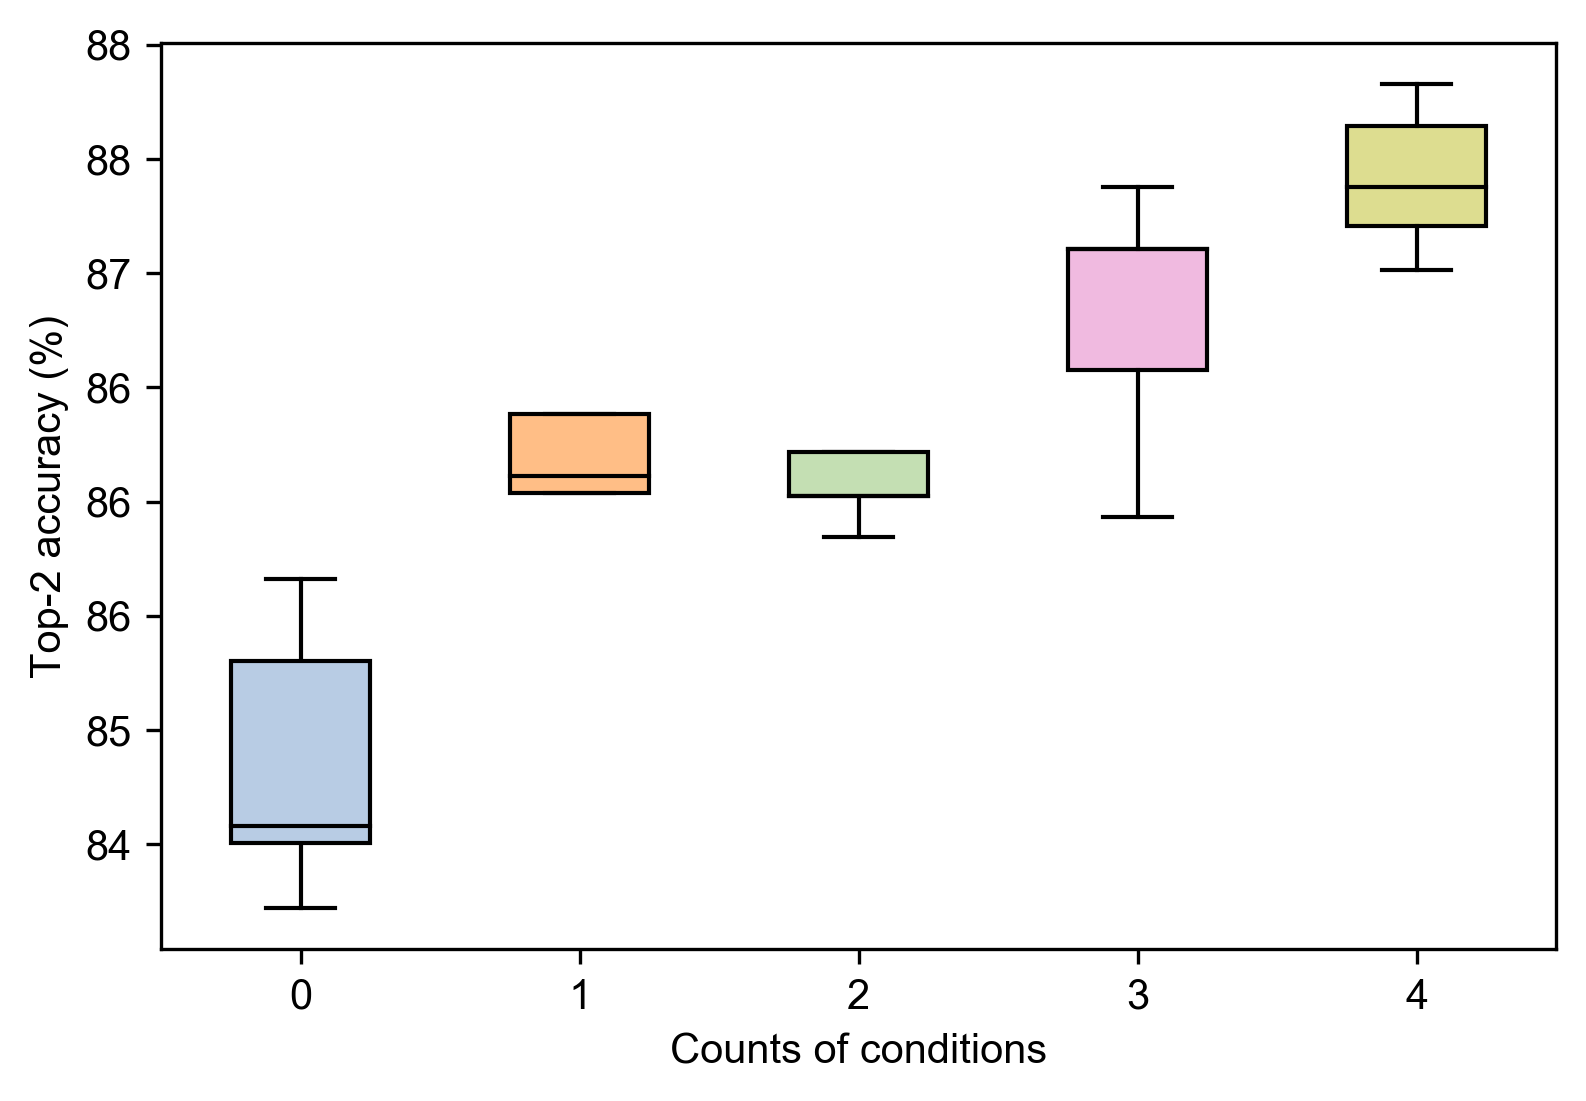

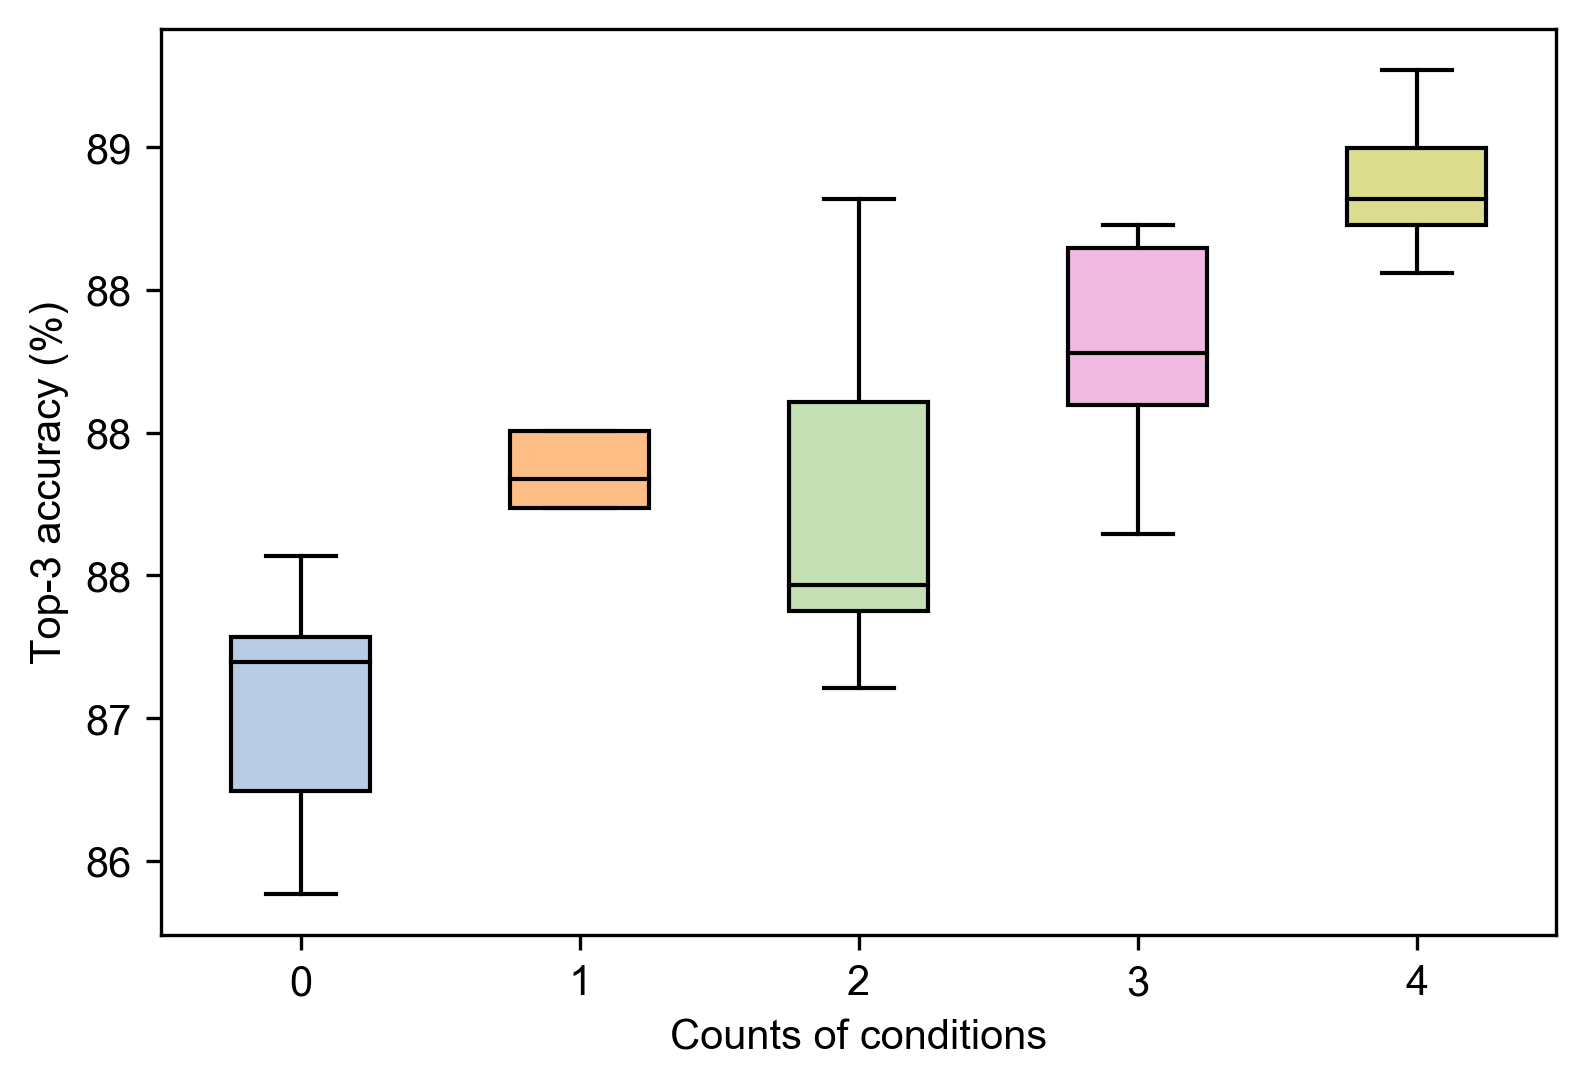

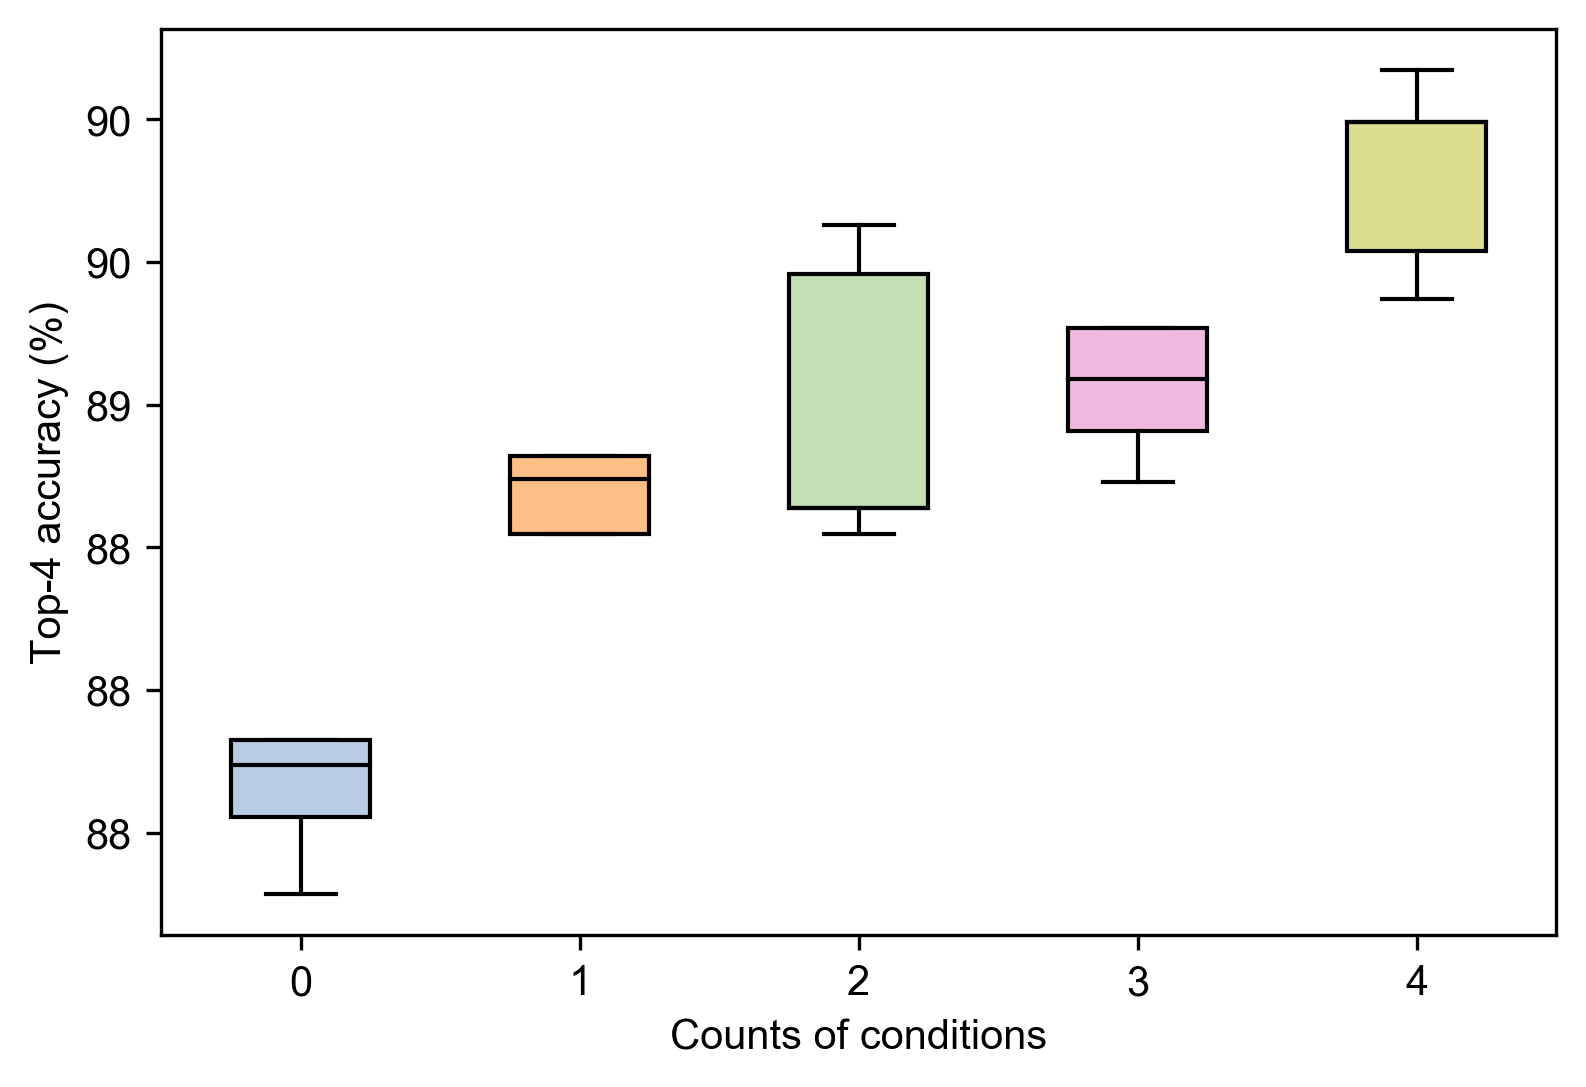

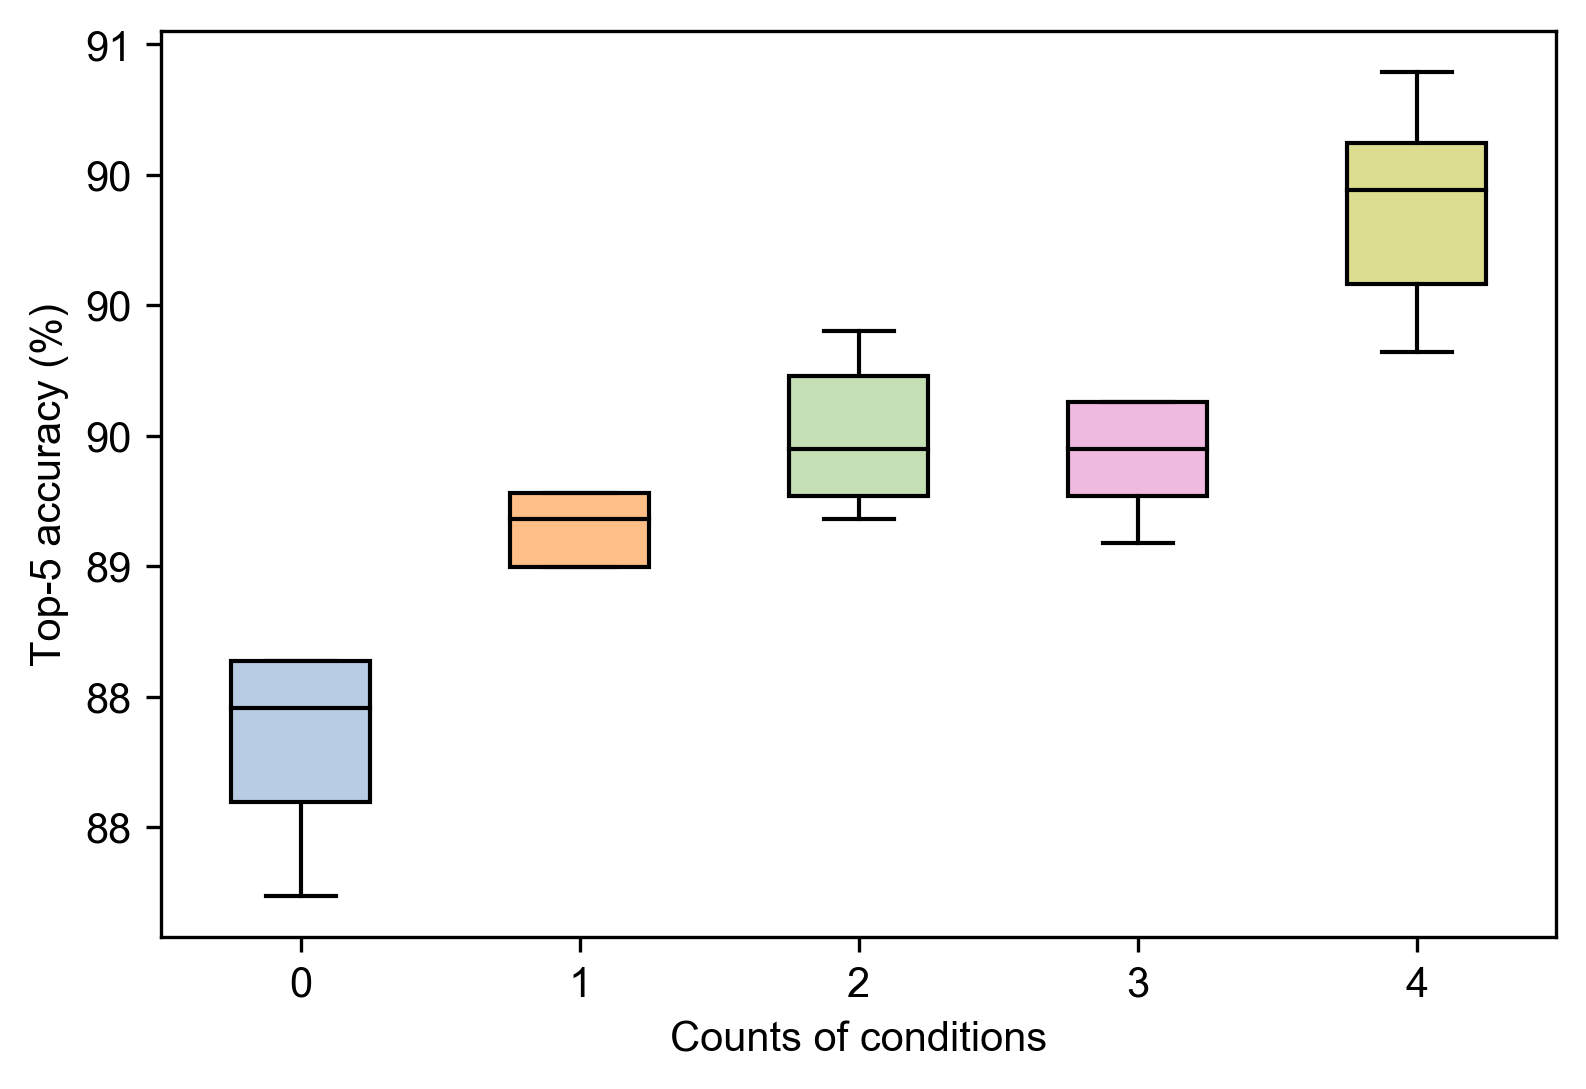

In [29]:
for top, group in best_df.groupby('top'):
    data = [subgroup['acc'].to_numpy() for ec, subgroup in group.groupby('ec')]
    boxplot(data, top)